# Triple Negative Breast Cancer(TNBC) Cell Semantic Segmentation

This notebook applies [U-Net](https://arxiv.org/abs/1505.04597) Convolutional Neural Network for semantic segmentation of TNBC cell images.

The dataset for the task is downloaded from [here](https://zenodo.org/record/1175282#.Xl_4nZMzZQJ) 

**Flow of the notebook:**
- Apply U-Net to standard dataset 
- Plot network's perfomance 
- Show sample test segmentation results 
- Apply U-Net to dataset "overlayed" with canny edges
- Plot network's perfomance 
- Show sample test segmentation results 
- Compare newtork's performance on both datasets

Let's get started!

# Triple Negative Breast Cancer

*Triple-negative breast cancer (TNBC) accounts for about 10-15%  of all breast cancers. These cancers tend to be more common in women younger than age 40, who are African-American.*

*Triple-negative breast cancer differs from other types of invasive breast cancer in that they grow and spread faster, have limited treatment options, and a worse prognosis (outcome)*.  - **American Cancer Society**

Thus early stage cancer detection is required to provide proper treatment to the patient and reduce the risk of death due to cancer as detection of these cancer cells at later stages lead to more suffering and increases chances of death. Semantic segmentation of cancer cell images can be used to improvise the analysis and diagonsis of Breast Cancer! Below is such an attempt.

# U-Net

U-Net is a State of the Art CNN architecture for Bio-medical image segmentation. *The architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization.* It's a Fully Convolutional Network(FCN) therefore it can **work with arbitrary size images!**

<img src="img/U-Net_arch.png">

In [55]:
# To ensure GPU is enabled on Colab

%tensorflow_version 1.x
%matplotlib inline
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 1- Import required modules

In [0]:
from model import *
from augmentation import *
from metrics import *
from plots import *
from utils import *

In [0]:
#!unzip data1.zip- Folder which contains test and train datasets

### 1.1- How to arrange Directories for using ImageDataGenerator.flow_from_directory()?

- train
    * images
        * img
    * label
        * img
- test
    * images
        * img
    * label
        * img
        
**train, test, images, label,img** are all directories, where *img* is the directory containing images/segmentation masks .png images

In [61]:
# Loads and initalises the U-Net network

m=unet()
m.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 256, 256, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_49[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_50[0][0]                  
____________________________________________________________________________________________

/content/model.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


## 2- Model training on Standard Dataset

In [0]:
opt = Adam(lr=1E-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
m.compile(loss=dice_coef_loss, optimizer=opt, metrics=['accuracy', iou, F1, recall, precision]) # Keeping track of these metrics

### 2.1- Why Data Augmentation?

Our training set has **only 33 images** which is nothing when compared to modern day datasets like [ImageNet](http://www.image-net.org/) which has over 1M annotated examples. *But this is generally the case in Bio-medical tasks.* Thus I've used Data Augmentation extensively to increase the dataset.

### 2.2- Why I haven't used ImageNet for Transfer Learning?

You might be wondering why haven't I done "transfer learning" from ImageNet or any similar datasets? Afterall such pre-training is a standard for Deep Learning. 

ImageNet is a "natural image" dataset and I'm here tacking a very specific problem which has images very different from natural images. Thus such pre-training would provide *little* benefit to the performance. For detailed insight into this check [this](https://arxiv.org/abs/1902.07208) wonderful paper which digs deep into Transfer learning for Medical tasks.

In [79]:
checkpoint = ModelCheckpoint('unet_weights.hdf5', monitor='loss', 
                             verbose=1, save_best_only=True, mode='min') # Checkpoint to store "only" the best weights during training
                                                                         # Weights will be saved in file named 'unet_weights.hdf5'
train_generator=train_data_aug() # Peforms real-time Data Augmentation on the Training dataset. See augmentation.py for more details
results = m.fit_generator(train_generator, epochs=50, steps_per_epoch = 16, callbacks=[checkpoint])

Found 33 images belonging to 1 classes.
Found 33 images belonging to 1 classes.
Epoch 1/50
16/16 [==============================] - 4s 239ms/step - loss: 0.0245 - acc: 0.9006 - iou: 0.3719 - F1: 0.5371 - recall: 0.5645 - precision: 0.7365

Epoch 00001: loss improved from inf to 0.02453, saving model to unet_weights.hdf5
Epoch 2/50
16/16 [==============================] - 4s 232ms/step - loss: 0.0244 - acc: 0.8993 - iou: 0.3761 - F1: 0.5419 - recall: 0.5437 - precision: 0.7384

Epoch 00002: loss improved from 0.02453 to 0.02378, saving model to unet_weights.hdf5
Epoch 3/50
16/16 [==============================] - 4s 230ms/step - loss: 0.0259 - acc: 0.8938 - iou: 0.3737 - F1: 0.5401 - recall: 0.5401 - precision: 0.7584

Epoch 00003: loss did not improve from 0.02378
Epoch 4/50
16/16 [==============================] - 4s 230ms/step - loss: 0.0275 - acc: 0.8867 - iou: 0.3870 - F1: 0.5539 - recall: 0.5525 - precision: 0.7348

Epoch 00004: loss did not improve from 0.02378
Epoch 5/50
16/16 [

## 3- Plotting model's training history

### 3.1- Why is the Learning Curve such?

I've trained the model before many times and in previous trainings the "Learning Curve" was exactly as a good learning curve should be ie. noisyier but "trending" downward for Loss function.

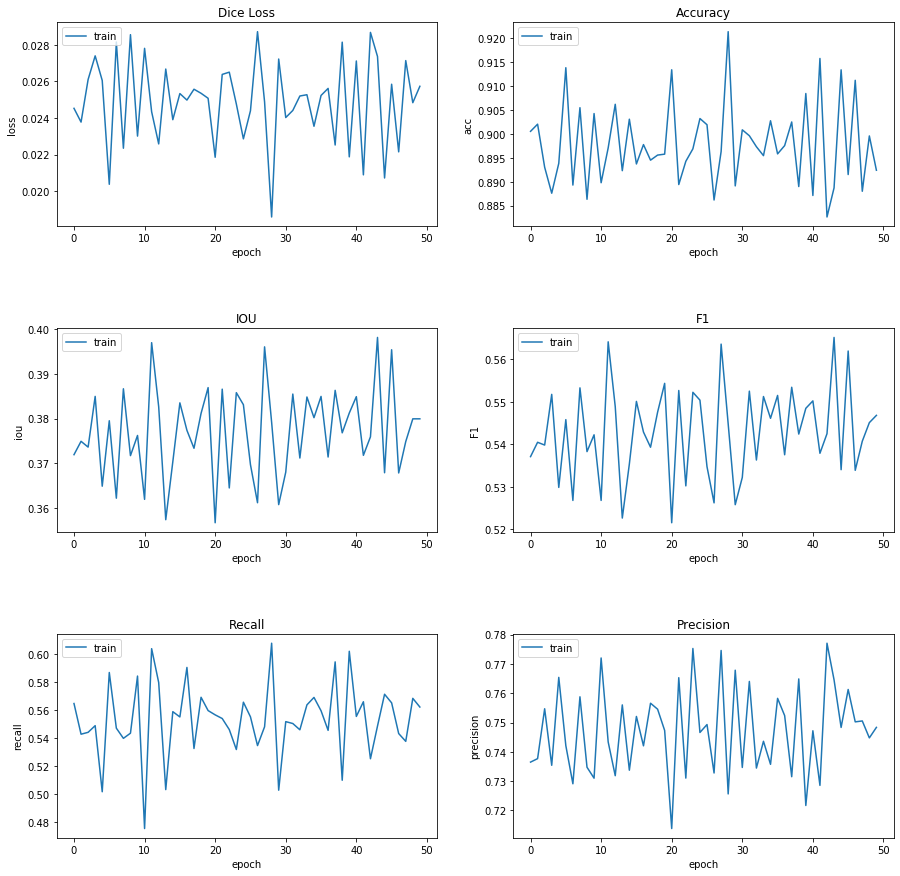

In [80]:
training_history_plot(results) # Plots "training curve" for the network/model for metrics listed above. See plots.py for more details

## 4- Model's Performance on various Metrics

In [81]:
titles = ['Dice Loss','Accuracy','IOU','F1','Recall','Precision']
test_generator=test_data_aug() # Peforms real-time Data Augmentation(here only re-scaling and converting to grayscale) on the Test/Validation dataset. See augmentation.py for more details
performance=m.evaluate_generator(test_generator, verbose=1,steps=17)

for i in range(6):
  print("%s = %f" %(titles[i], performance[i]))

Found 17 images belonging to 1 classes.
Found 17 images belonging to 1 classes.
17/17 [==============================] - 1s 39ms/step
Dice Loss = 0.043268
Accuracy = 0.891285
IOU = 0.241737
F1 = 0.381021
Recall = 0.337300
Precision = 0.727956


In [0]:
#!unzip test2.zip- Folder which contains the dataset for Test performance evaluation

### 4.1- Structure of test2 directory

- test2
    * 0
        * 0
            * 0.png
    * 1
        * 1
            * 1.png
            
Such weird file structure is because there should be **"two" nested directories** in the container directory(test2)

In [82]:
results=np.zeros(shape=(17,256,256,1))
for i in range(17): # As we have 17 test images 
  results[i,:,:,:]=predict(i, m) # Predicts the segmentation labels on images in test2 directory. See utils.py for more details

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 49ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 44ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 51ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 49ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 51ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 51ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 55ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 45ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 45ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 51ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 54ms/step

## 5- Sample Results

Starting from the left:
    - First image is original test image "converted" to grayscale
    - Second is the predicted segmentation labels for above image
    - Third one is a Binary mask ie. pixel values of only 0's and 1's, obtained by thresholding on Predicted segmentation, below is for threshold value 0.2, implies all pixel values greater than 0.2 in Predicted segmentation get 1 and others get 0
    - Rightmost is the Ground Truth segmentation label for this test image
    
Below we see that segmentation results are very good considering the fact that we had only 33 images our training dataset which is very limited! 

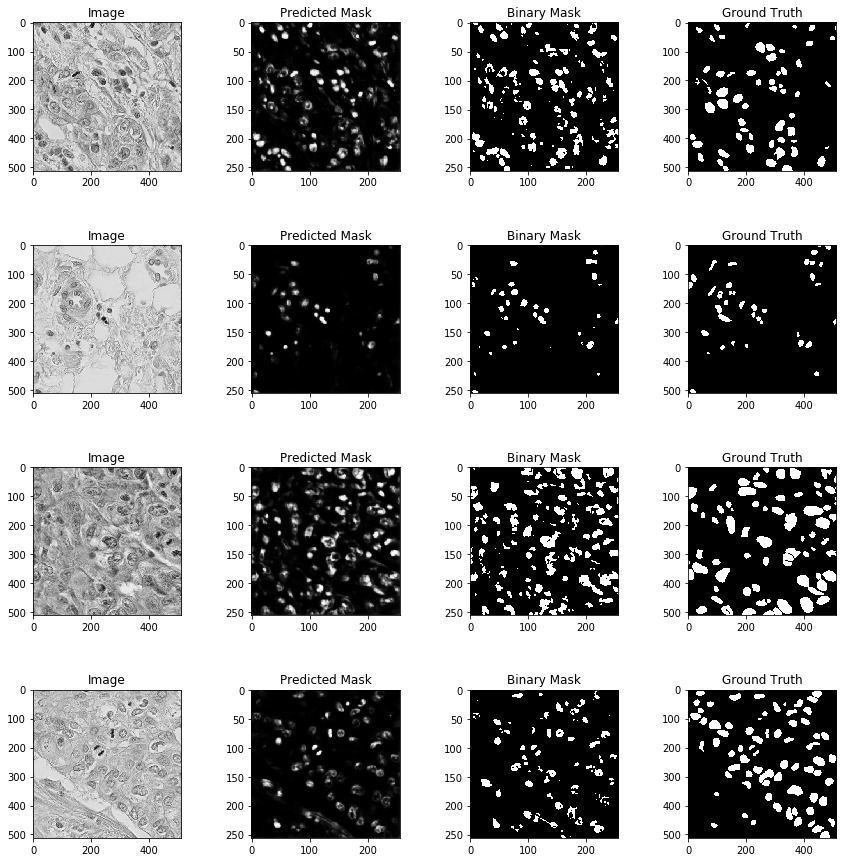

In [87]:
model_prediction_plot(results, t=0.2) # See plots.py for more details

In [4]:
# Loads and initalises another U-Net network. This will be trained on dataset "overlayed" with their corresponding Canny Edges

m_c=unet()
m_c.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv

/content/model.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


In [0]:
#!unzip canny.zip- Folder which contains test and train datasets overlayed with Canny Edges

In [0]:
opt_c = Adam(lr=1E-7, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
m_c.compile(loss=dice_coef_loss, optimizer=opt_c, metrics=['accuracy', iou, F1, recall, precision])

## 6- Model training on Canny Dataset

In [49]:
checkpoint_c = ModelCheckpoint('unet_canny_weights.hdf5', monitor='loss', 
                             verbose=1, save_best_only=True, mode='min') # Different checkpoint for storing "only" best wieghts during training
                                                                         # Weights will be saved in file named 'unet_canny_weights.hdf5'
train_generator_c=train_data_aug(True) # Peforms real-time Data Augmentation on the Canny Training dataset. See augmentation.py for more details
results_c = m_c.fit_generator(train_generator_c, epochs=50, steps_per_epoch = 16, callbacks=[checkpoint_c])

Found 33 images belonging to 1 classes.
Found 33 images belonging to 1 classes.
Epoch 1/50
16/16 [==============================] - 6s 395ms/step - loss: 0.0266 - acc: 0.9025 - iou: 0.2749 - F1: 0.4294 - recall: 0.4792 - precision: 0.7099

Epoch 00001: loss improved from inf to 0.02657, saving model to unet_canny_weights.hdf5
Epoch 2/50
16/16 [==============================] - 4s 229ms/step - loss: 0.0271 - acc: 0.9010 - iou: 0.2773 - F1: 0.4321 - recall: 0.4861 - precision: 0.7041

Epoch 00002: loss improved from 0.02657 to 0.02634, saving model to unet_canny_weights.hdf5
Epoch 3/50
16/16 [==============================] - 4s 230ms/step - loss: 0.0282 - acc: 0.8965 - iou: 0.2797 - F1: 0.4355 - recall: 0.4827 - precision: 0.7183

Epoch 00003: loss did not improve from 0.02634
Epoch 4/50
16/16 [==============================] - 4s 230ms/step - loss: 0.0307 - acc: 0.8874 - iou: 0.2822 - F1: 0.4384 - recall: 0.4867 - precision: 0.6834

Epoch 00004: loss did not improve from 0.02634
Epoch 

## 7- Plotting model's training history on Canny dataset

### 7.1- Why is the Learning Curve such?

I've trained the model before many times and in previous trainings the "Learning Curve" was exactly as a good learning curve should be ie. noisier but "trending" downwards for the Loss function.

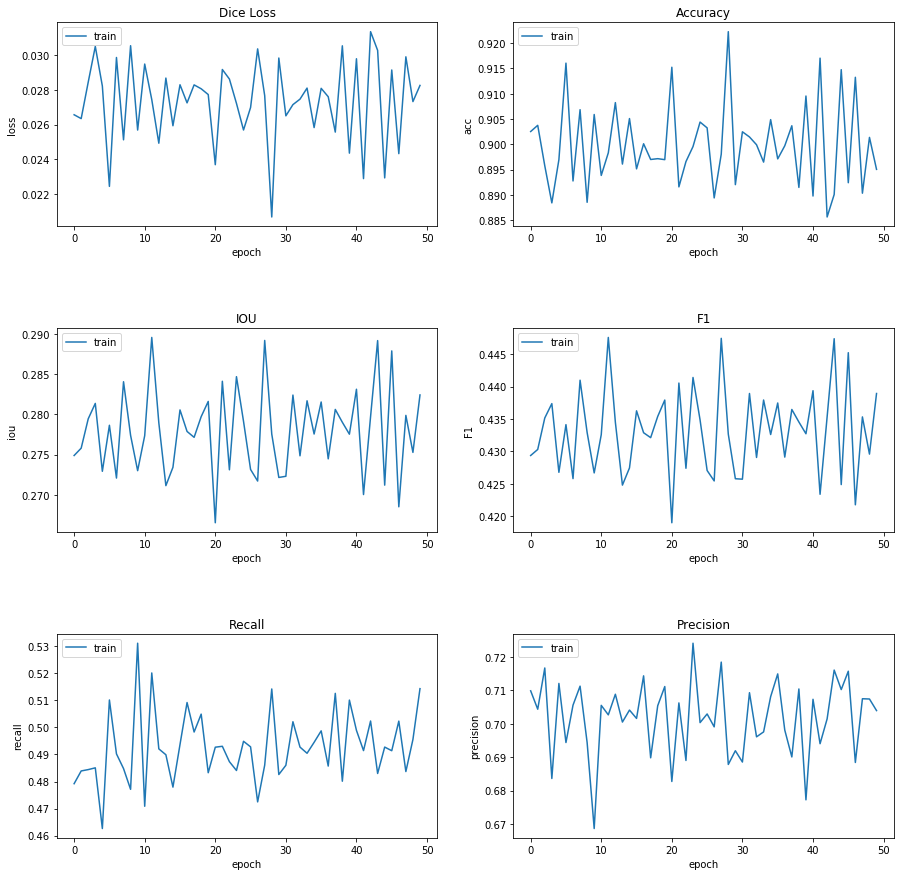

In [50]:
training_history_plot(results_c)

## 8- Model's Performance on various Metrics trained on Canny dataset

In [51]:
titles = ['Dice Loss','Accuracy','IOU','F1','Recall','Precision']
test_generator_c=test_data_aug(True) # Peforms real-time Data Augmentation(here only re-scaling and converting to grayscale) on the Test/Validation Canny dataset. See augmentation.py for more details
performance_c=m_c.evaluate_generator(test_generator_c, verbose=1,steps=17)

for i in range(6):
  print("%s = %f" %(titles[i], performance_c[i]))

Found 17 images belonging to 1 classes.
Found 17 images belonging to 1 classes.
17/17 [==============================] - 1s 61ms/step
Dice Loss = 0.043531
Accuracy = 0.899106
IOU = 0.236106
F1 = 0.375546
Recall = 0.557604
Precision = 0.640388


In [52]:
results_c=np.zeros(shape=(17,256,256,1))
# Predicts the segmentation labels on images in test2 directory. Note: Test dataset has also undergone Canny "overlay"
# as our model was trained on Canny "overlayed" images 
for i in range(17):
  results_c[i,:,:,:]=predict(i, m_c) # See utils.py for more details

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 409ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 44ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 56ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 48ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 50ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 53ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 50ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 43ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 44ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 48ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 50ms/ste

## 9- Sample Results on Canny Dataset

Starting from the left:
    - First image is original test image "converted" to grayscale
    - Second is the predicted segmentation labels for above image
    - Third one is a Binary mask ie. pixel values of only 0's and 1's, obtained by thresholding on Predicted segmentation, below is for threshold value 0.3, implies all pixel values greater than 0.3 in Predicted segmentation get 1 and others get 0
    - Rightmost is the Ground Truth segmentation label for this test image
    
Below we see that segmentation results are very good considering the fact that we had only 33 images our training dataset which is very limited! 

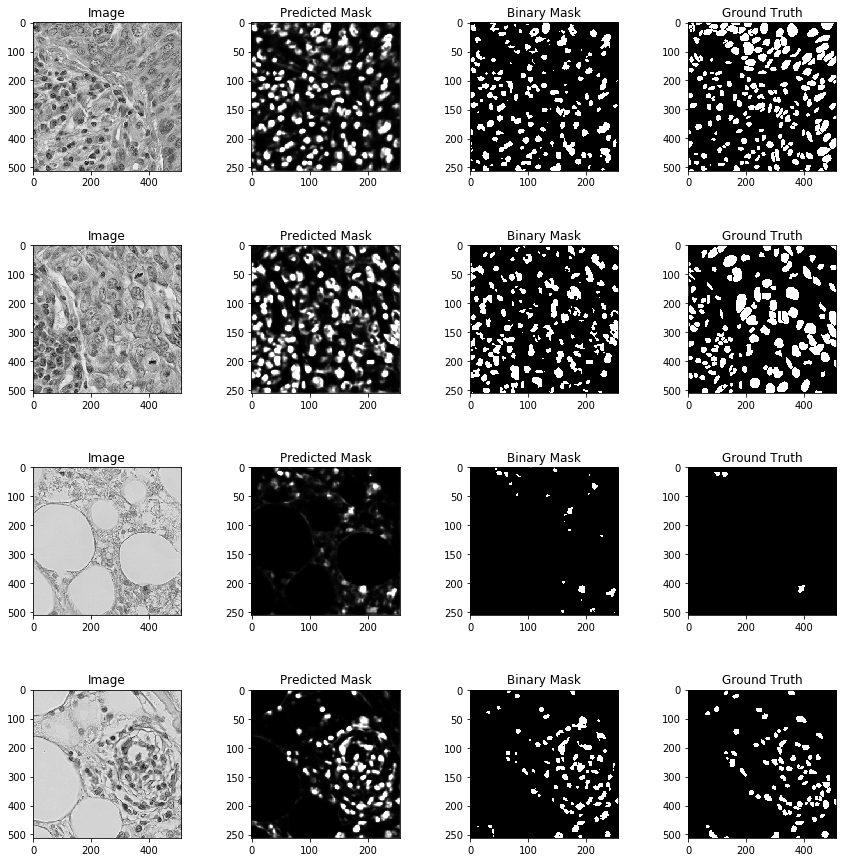

In [54]:
model_prediction_plot(results_c, 0.3) # See plots.py for more details

## 10- Comparing model's prediction for both Dataset training

Starting from the left:
    - First image is original test image "converted" to grayscale
    - Second is the predicted segmentation labels for above image using model trained on Standard Dataset
    - Third one is the predicted segmentation labels for above image using model trained on Canny "overlayed" Dataset
    - Fourth is a Binary mask ie. pixel values of only 0's and 1's, obtained by thresholding on Predicted segmentation(from Standard dataset), below is for threshold value 0.1(see plots.py), implies all pixel values greater than 0.1 in Predicted segmentation get 1 and others get 0
    - Fifth one is a Binary mask ie. pixel values of only 0's and 1's, obtained by thresholding on Predicted segmentation(from Canny "overlayed" dataset), below is for threshold value 0.2(see plots.py), implies all pixel values greater than 0.2 in Predicted segmentation get 1 and others get 0
    - Rightmost is the Ground Truth segmentation label for this test image
    
***Below we see that segmentation results from model trained on Canny dataset is better than the one trained on the Standard Dataset!***

**Note:** The text labels for 3rd and 4th images below are swapped, the correct order is as listed above

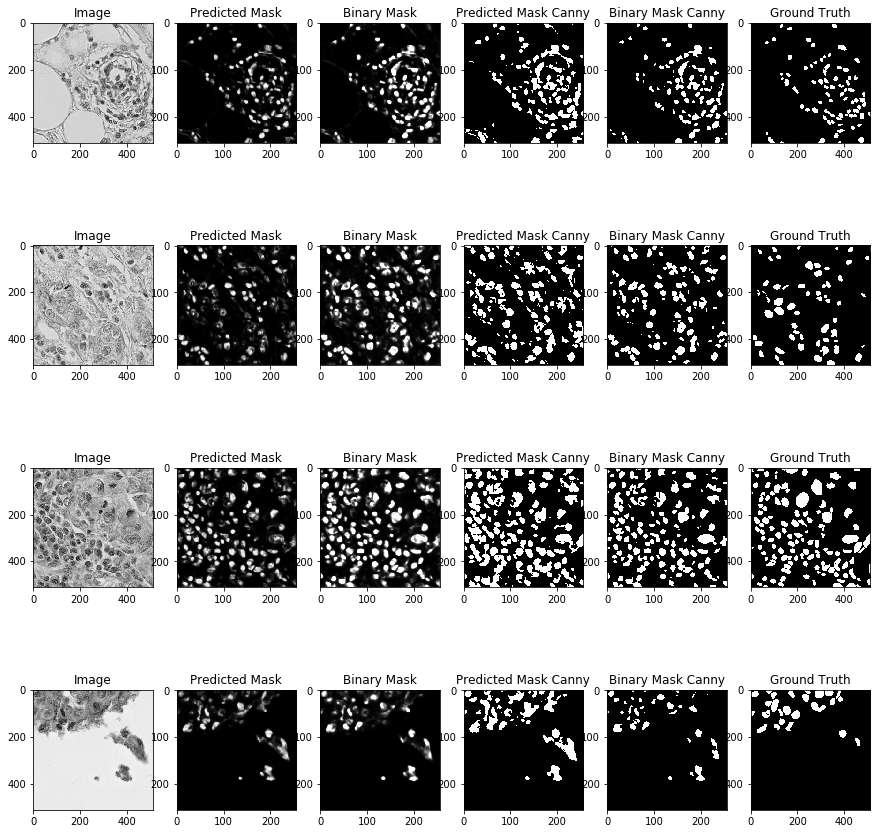

In [89]:
canny_compare_plot(results, results_c) # Compares model's performance on the "standard" dataset and dataset "overlayed" with "canny edges"

## 11- References

1. [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)
2. [Triple Negative Breast Cancer- American Cancer Society](https://www.cancer.org/cancer/breast-cancer/understanding-a-breast-cancer-diagnosis/types-of-breast-cancer/triple-negative.html)
3. [Deep Learning for Cancer Cell Detection and Segmentation: A Survey](https://www.researchgate.net/publication/334080872_Deep_Learning_for_Cancer_Cell_Detection_and_Segmentation_A_Survey)
4. [Transfusion: Understanding Transfer Learning for Medical Imaging](https://arxiv.org/abs/1902.07208)
5. [Dataset](https://zenodo.org/record/1175282#.Xl_4nZMzZQJ)

**Note:** Not an exhaustive list